In [1]:
import torch.nn.functional as F
import voc12.dataloader
import argparse
import torch
import os
import numpy as np
from torch.utils.data import DataLoader
from misc import pyutils, torchutils
from net.resnet50_cam import Net
from torch import nn
from torchvision.transforms import transforms

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
class GaussianBlur(object):
    """blur a single image on CPU"""
    def __init__(self, kernel_size):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1),
                                stride=1, padding=0, bias=False, groups=3)
        self.blur_v = nn.Conv2d(3, 3, kernel_size=(1, kernel_size),
                                stride=1, padding=0, bias=False, groups=3)
        self.k = kernel_size
        self.r = radias

        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )

        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)

        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)

        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))

        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()

        img = self.tensor_to_pil(img)

        return img

def get_simclr_pipeline_transform(size, s=1):
    """Return a set of data augmentation transformations as described in the SimCLR paper."""
    color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomApply([color_jitter], p=0.8),
                                            transforms.RandomGrayscale(p=0.2),
                                            GaussianBlur(kernel_size=int(0.1 * size)),
                                            transforms.RandomSolarize(threshold=0.5, p=0.2),
                                            transforms.ToTensor(),
                                            transforms.Normalize(
                                                mean=torch.tensor([0.485, 0.456, 0.406]),
                                                std=torch.tensor([0.229, 0.224, 0.225]))])
    return data_transforms

In [3]:
simclr = get_simclr_pipeline_transform(512)

def get_img_path(img_name, voc12_root):
    if not isinstance(img_name, str):
        img_name = decode_int_filename(img_name)
    return os.path.join(voc12_root, 'JPEGImages', img_name + '.jpg')

In [4]:
val_list = '/Users/Andy/Projects/front_door_cam/voc12/val.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'

train_dataset = voc12.dataloader.VOC12ClassificationDataset(val_list, voc12_root=voc12_root,
                                                            resize_long=(320, 640), hor_flip=True,
                                                            crop_size=512, crop_method="random")
train_data_loader = DataLoader(train_dataset,
                               batch_size=16,
                               shuffle=False,
                               num_workers=1,
                               pin_memory=True,
                               drop_last=True)


data_iter = iter(train_data_loader)
pack = next(data_iter)

In [5]:
imgs = pack['img']
print(pack.keys())
names = pack['name']
print(imgs.shape)

dict_keys(['name', 'img', 'label'])
torch.Size([16, 3, 512, 512])


In [6]:
def plot_batch(names, voc12_root):
    w = 512
    h = 512
    fig = plt.figure(figsize=(16, 16))
    columns = 4
    rows = 4
    for i in range(1, columns * rows +1):
        im = Image.open(get_img_path(names[i-1], voc12_root)).convert('RGB')
        im = simclr(im)
        fig.add_subplot(rows, columns, i)
        im = im.numpy().squeeze().transpose(1, 2, 0)
        im = (im - im.min()) / (im.max() - im.min())
        plt.imshow(im)
        plt.title(names[i-1])
    plt.show()

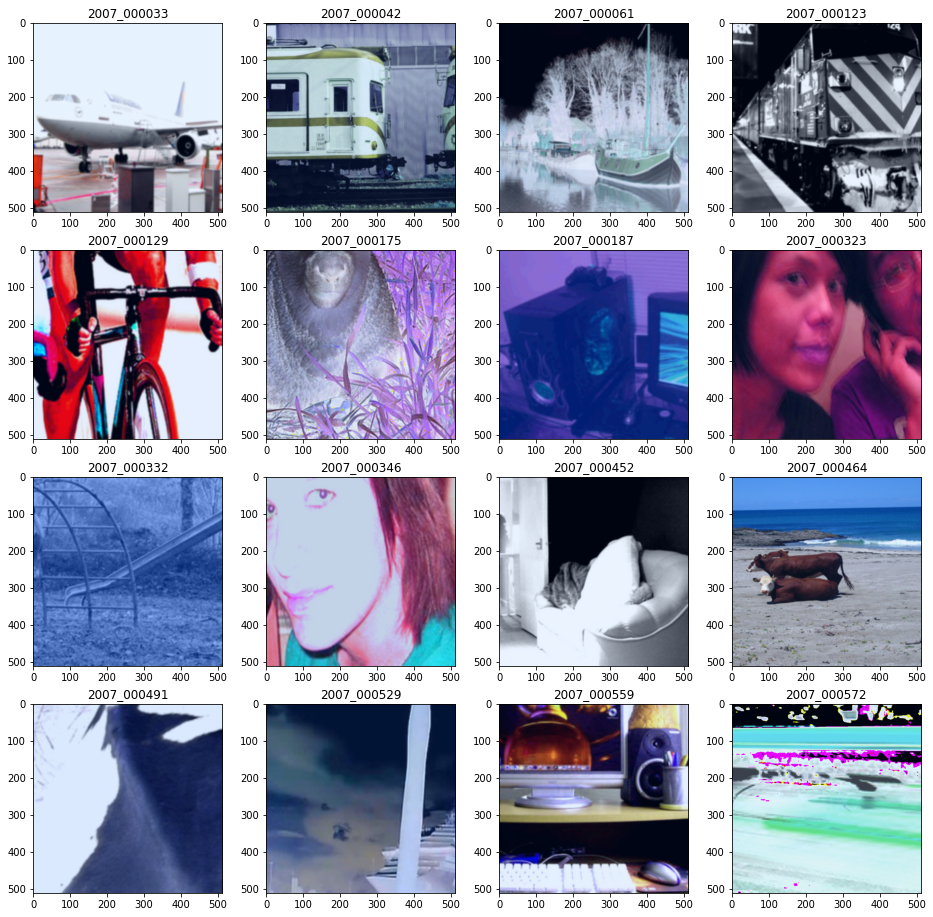

In [7]:
plot_batch(names, voc12_root)

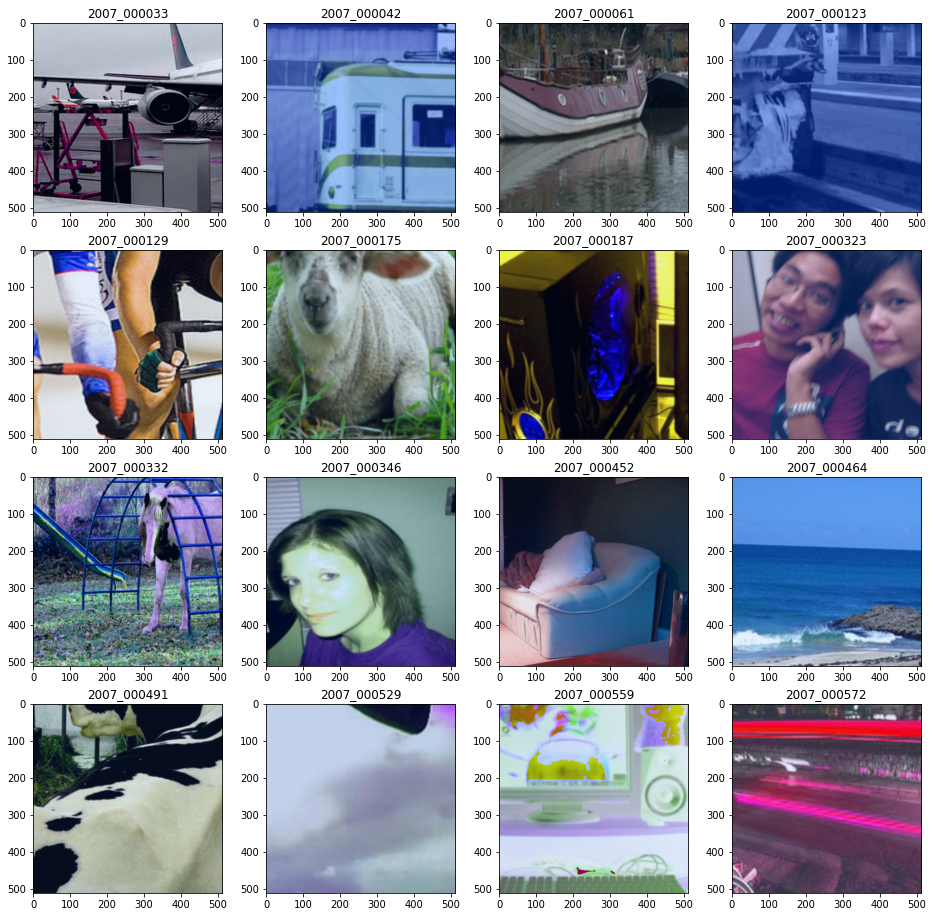

In [8]:
plot_batch(names, voc12_root)

In [24]:
class FC(nn.Module):
    def __init__(self, input_dim=20, output_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        return x
    
fc = FC()
m = Net()

optimizer = torch.optim.SGD([
                {'params': fc.parameters()},
                {'params': m.parameters(), 'lr': 1e-3}
            ], lr=1e-2, momentum=0.9)

In [25]:
def sim_aug(names):
    ims = []
    for n in names:
        im = simclr(Image.open(get_img_path(n, voc12_root)).convert('RGB')).unsqueeze(0)
        ims += [im]
    return torch.cat(ims, dim=0)

aug_l = sim_aug(names)
aug_k = sim_aug(names)

aug_q = sim_aug(names)
aug_t = sim_aug(names)

optimizer.zero_grad()
feat_l = m(aug_l)
feat_k = m(aug_k)

feat_q = m(aug_q)
feat_t = m(aug_t)

In [26]:
proj_l = fc(feat_l)
proj_k = fc(feat_k)

proj_q = fc(feat_q)
proj_t = fc(feat_t)

In [27]:
def sim_score(proj_a, proj_b):
    score = torch.matmul(proj_a, proj_b.permute(1, 0))
    return score # each row is proj_a's row to all rows in proj_b

In [28]:
score_lk = sim_score(proj_l, proj_k)
score_qt = sim_score(proj_q, proj_t)

In [29]:
logprob_lk = torch.nn.functional.log_softmax(score_lk, dim=1)
logprob_qt = torch.nn.functional.log_softmax(score_qt, dim=1)

In [30]:
kl_loss = torch.nn.KLDivLoss(log_target=True, reduction='batchmean')(logprob_lk, logprob_qt)
print(kl_loss)

tensor(0.0012, grad_fn=<DivBackward0>)


In [31]:
kl_loss.backward()